In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# CNN

## Image generators

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255,
    rotation_range = 10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

imgdir = '/content/gdrive/MyDrive'
img_height = 320
img_width = 240
batch_size = 16
batch_size_easy = 10

train_generator_unbalanced = data_gen.flow_from_directory(
        imgdir + '/trams',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=True,
        subset='training')

validation_generator_unbalanced = data_gen_valid.flow_from_directory(
        imgdir + '/trams',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=False,
        subset='validation')

train_generator_balanced = data_gen.flow_from_directory(
        imgdir + '/model2_v3_balanced',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=True,
        subset='training')

validation_generator_balanced = data_gen_valid.flow_from_directory(
        imgdir + '/model2_v3_balanced',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=False,
        subset='validation')

train_generator_easy = data_gen.flow_from_directory(
        imgdir + '/model2_easy_xtra',
        target_size=(img_height, img_width),
        batch_size=batch_size_easy,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=True,
        subset='training')

validation_generator_easy= data_gen_valid.flow_from_directory(
        imgdir + '/model2_easy_xtra',
        target_size=(img_height, img_width),
        batch_size=batch_size_easy,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=False,
        subset='validation')

Found 816 images belonging to 11 classes.
Found 198 images belonging to 11 classes.
Found 517 images belonging to 11 classes.
Found 121 images belonging to 11 classes.
Found 165 images belonging to 11 classes.
Found 33 images belonging to 11 classes.


## Model set up

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def make_convnet_categorical(input_shape=(img_height, img_width, 3)):
  model = Sequential()
  model.add(Conv2D(32, 3, strides = 2,
                    activation = 'relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(64, kernel_size=(3,3), strides= 2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  
  model.add(Conv2D(128, kernel_size=(3,3), strides= 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  print(model.summary())
  
  model.add(Flatten())
  
  model.add(Dense(500, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(11, activation='softmax'))
  return model


## Adam optimizer

In [ ]:
from keras.callbacks import ModelCheckpoint
np.random.seed(42)
# Full data set
checkpoint1 = ModelCheckpoint("best_model1.keras", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_full = make_convnet_categorical()
convnet_full.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_full.fit(train_generator_unbalanced, epochs = 20, 
                 validation_data=validation_generator_unbalanced, callbacks = [checkpoint1])
# Balanced data set
checkpoint5 = ModelCheckpoint("best_model5.keras", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_bal = make_convnet_categorical()
convnet_bal.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_bal.fit(train_generator_balanced, epochs = 20, 
                 validation_data=validation_generator_balanced, callbacks = [checkpoint5])
# Easy data set
checkpoint2 = ModelCheckpoint("best_model2.keras", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_easy = make_convnet_categorical()
convnet_easy.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_easy.fit(train_generator_easy, epochs = 20, 
                 validation_data=validation_generator_easy, callbacks = [checkpoint2])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 159, 119, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 79, 59, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 39, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 19, 14, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 17, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 6, 128)         0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_________________________________________________

## SGD

In [ ]:
from keras.callbacks import ModelCheckpoint
np.random.seed(42)
# Full data set
checkpoint3 = ModelCheckpoint("best_model3.keras", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_full_sgd = make_convnet_categorical()
convnet_full_sgd.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_full_sgd.fit(train_generator_unbalanced, epochs = 20, 
                    steps_per_epoch = train_generator_unbalanced.labels.size// batch_size, 
                    validation_data=validation_generator_unbalanced, 
                    validation_steps = validation_generator_unbalanced.labels.size,
                    callbacks = [checkpoint3])
# Balanced data set
checkpoint6 = ModelCheckpoint("best_model6.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_bal_sgd = make_convnet_categorical()
convnet_bal_sgd.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_bal_sgd.fit(train_generator_balanced, epochs = 20, 
                 validation_data=validation_generator_balanced, 
                 steps_per_epoch = train_generator_balanced.labels.size // batch_size,
                 validation_steps = validation_generator_balanced.labels.size // batch_size,
                 callbacks = [checkpoint6])
# Easy data set
checkpoint4 = ModelCheckpoint("best_model4.keras", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_easy_sgd = make_convnet_categorical()
convnet_easy_sgd.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_easy_sgd.fit(train_generator_easy, epochs = 20, 
                 steps_per_epoch = train_generator_balanced.labels.size // batch_size_easy,
                 validation_steps = validation_generator_easy.labels.size // batch_size_easy,
                 validation_data=validation_generator_easy, 
                 callbacks = [checkpoint4])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 159, 119, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 79, 59, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 39, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 6, 128)         0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
__________________________________________________

' \n# Easy data set\ncheckpoint4 = ModelCheckpoint("best_model4.keras", monitor=\'val_loss\', verbose=1,\n    save_best_only=True, mode=\'auto\', period=1)\nconvnet_easy_sgd = make_convnet_categorical()\nconvnet_easy_sgd.compile(\'sgd\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\nconvnet_easy_sgd.fit(train_generator_easy, epochs = 20, \n                 steps_per_epoch = train_generator_balanced.labels.size // batch_size_easy,\n                 validation_steps = validation_generator_easy.labels.size // batch_size_easy,\n                 validation_data=validation_generator_easy, \n                 callbacks = [checkpoint4])\n'

## Evaluation

### Plot confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from keras.models import load_model
import seaborn as sns

def model_eval(model, modelname, generator, batch_size, imgdir = imgdir):
  target_names=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
  #target_names=[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  Y_pred = model.predict_generator(generator, np.ceil(generator.labels.size / batch_size))
  y_pred = np.argmax(Y_pred, axis=1)
  #print('Confusion Matrix')
  im = sns.heatmap(confusion_matrix(generator.classes, y_pred),xticklabels= target_names, yticklabels=target_names, annot = True)
  im.set_ylabel("True labels")
  im.set_xlabel("Predicted labels")
  im.set_title("Confusion matrix")
  #print('Classification Report')
  report = classification_report(generator.classes, y_pred, target_names = target_names)
  return im, report

def model_eval_saved(modelname, generator, batch_size, imgdir = imgdir):
  target_names=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
  #target_names=[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  model = load_model(modelname)
  model.save(imgdir + "/" + modelname)
  Y_pred = model.predict_generator(generator, np.ceil(generator.labels.size / batch_size))
  y_pred = np.argmax(Y_pred, axis=1)
  #print('Confusion Matrix')
  im = sns.heatmap(confusion_matrix(generator.classes, y_pred),xticklabels= target_names, yticklabels=target_names, annot = True)
  im.set_ylabel("True labels")
  im.set_xlabel("Predicted labels")
  im.set_title("Confusion matrix")
  #print('Classification Report')
  report = classification_report(generator.classes, y_pred, target_names = target_names)
  return im, report
  

Best val loss model


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        11
           3       0.20      0.55      0.29        11
           4       0.00      0.00      0.00        11
           5       0.12      0.09      0.11        11
           6       0.18      0.55      0.27        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
          10       0.14      0.45      0.21        11
          11       0.00      0.00      0.00        11

    accuracy                           0.15       121
   macro avg       0.06      0.15      0.08       121
weighted avg       0.06      0.15      0.08       121



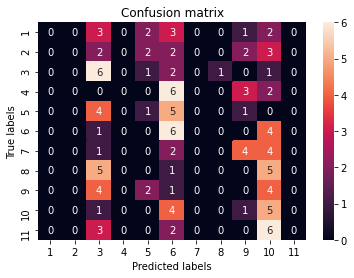

In [ ]:
import matplotlib.pyplot as plt
# Model with best val_loss
print("Best val loss model")
im_1, report_1 = model_eval_saved("best_model6.h5", validation_generator_balanced, batch_size)
plt.savefig(imgdir+"/conf_mat_valloss.jpg")
print(report_1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        11
           3       0.20      0.09      0.13        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.06      0.27      0.09        11
           7       0.00      0.00      0.00        11
           8       0.12      0.18      0.15        11
           9       0.00      0.00      0.00        11
          10       0.17      0.36      0.24        11
          11       0.00      0.00      0.00        11

    accuracy                           0.08       121
   macro avg       0.05      0.08      0.05       121
weighted avg       0.05      0.08      0.05       121



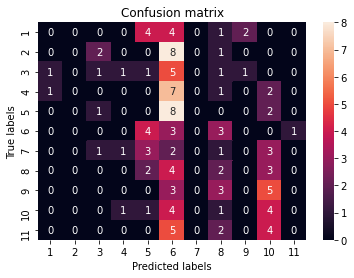

In [ ]:
# Model from last epoch
im_2, report_2 = model_eval(convnet_bal_sgd, "mod_last_epoch", validation_generator_balanced, batch_size)
plt.savefig(imgdir+"/conf_mat_last_epoch.jpg")
print(report_2)

## Regularization of best model (SGD, balanced data set)

### New model setup

In [ ]:
def make_convnet_categorical_2(input_shape=(img_height, img_width, 3)):
  model = Sequential()
  reg = regularizers.l1_l2(l1=1e-1, l2=1e-1)

  l1 = 16
  model.add(Conv2D(l1, kernel_size=(3,3), padding="same", activation = 'relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  l2 = 32
  model.add(Conv2D(l2, kernel_size=(3,3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  
  l3 = 64
  model.add(Conv2D(l3, kernel_size=(3,3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  l4 = 128
  model.add(Conv2D(l4, kernel_size=(3,3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Flatten())

  model.add(Dense(1280, activation='relu', kernel_regularizer=reg))
  model.add(Dense(11, activation='softmax'))
  return model

### Train model

In [ ]:
from keras.callbacks import ModelCheckpoint
batch_size_2 = 64
train_generator_balanced_2 = data_gen.flow_from_directory(
        imgdir + '/model2_v3_balanced',
        target_size=(img_height, img_width),
        batch_size=batch_size_2,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=True,
        subset='training')

validation_generator_balanced_2 = data_gen_valid.flow_from_directory(
        imgdir + '/model2_v3_balanced',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
        seed=12345,
        shuffle=False,
        subset='validation')

checkpoint_reg = ModelCheckpoint("best_model_reg.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
convnet_bal_sgd = make_convnet_categorical()
convnet_bal_sgd.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
convnet_bal_sgd.fit(train_generator_balanced_2, epochs = 200,
                    steps_per_epoch = train_generator_balanced_2.labels.size // batch_size_2,
                    validation_steps = validation_generator_balanced_2.labels.size // batch_size, 
                 validation_data=validation_generator_balanced_2, callbacks = [checkpoint_reg])

Found 517 images belonging to 11 classes.
Found 121 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 159, 119, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 6, 128)         0         
Total params: 93,248
Trainable params:

### Evaluation

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.11      0.18      0.13        11
           2       0.00      0.00      0.00        11
           3       0.08      0.18      0.11        11
           4       0.00      0.00      0.00        11
           5       0.14      0.27      0.19        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.20      0.09      0.13        11
           9       0.00      0.00      0.00        11
          10       0.11      0.18      0.13        11
          11       0.00      0.00      0.00        11

    accuracy                           0.08       121
   macro avg       0.06      0.08      0.06       121
weighted avg       0.06      0.08      0.06       121



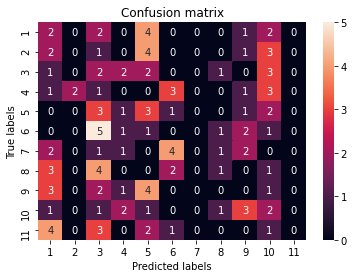

In [ ]:
import matplotlib.pyplot as plt
im_3, report_3 = model_eval_saved("best_model_reg.h5", validation_generator_balanced_2, batch_size)
plt.savefig(imgdir+"/conf_mat_reg_.jpg")
print(report_3)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.08      0.09      0.08        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.08      0.09      0.08        11
           6       0.14      0.18      0.16        11
           7       0.11      0.09      0.10        11
           8       0.00      0.00      0.00        11
           9       0.17      0.18      0.17        11
          10       0.14      0.18      0.16        11
          11       0.08      0.18      0.11        11

    accuracy                           0.09       121
   macro avg       0.07      0.09      0.08       121
weighted avg       0.07      0.09      0.08       121



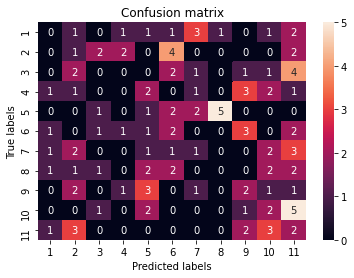

In [ ]:
im_4, report_4 = model_eval(convnet_bal_sgd, "reg_best_val", validation_generator_balanced_2, batch_size)
plt.savefig(imgdir+"/conf_mat_reg_last.jpg")
print(report_4)